In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tud
import numpy as np
from typing import Callable, Any, List, Dict
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

class Net(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 num_layers: int,
                 output_activation: Callable,
                 nonlinearity = 'tanh'
                ):
        super(Net, self).__init__()
        self.hidden = nn.RNN(
            input_size, hidden_size, num_layers,
            nonlinearity = nonlinearity, batch_first = True
        )
        self.output = nn.Linear(hidden_size, output_size)
        self.g = output_activation
        nn.init.xavier_uniform_(self.output.weight, gain=1.0)

    def forward(self, x: torch.Tensor, h_0 = None):
        # x.size() = (batch_size, sequence_length, num_features)
        # Hidden layers
        h, h_n = self.hidden(x, h_0)
        # Output layer
        y = self.g(self.output(h))
        return y[:, -1, :]

Epoch: 1   Train Loss: 0.3925   Test Loss: 0.4050
Epoch: 100   Train Loss: 0.0024   Test Loss: 0.0027
Epoch: 200   Train Loss: 0.0020   Test Loss: 0.0021
Epoch: 300   Train Loss: 0.0020   Test Loss: 0.0019
Epoch: 400   Train Loss: 0.0018   Test Loss: 0.0019
Epoch: 500   Train Loss: 0.0016   Test Loss: 0.0017


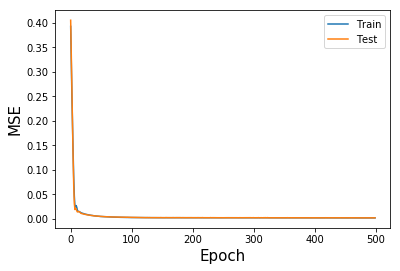

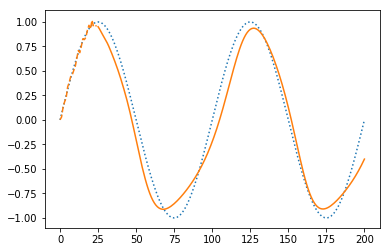

In [5]:
# -------------------< Toy Problem(Predict sin wave) >-------------------
if  __name__ == '__main__':
    def toy_problem(T = 100, A = 0.05):
        x = np.arange(0, 2 * T + 1)
        noise = A * np.random.uniform(low = - 1.0, high = 1.0, size = len(x))
        return np.sin(2.0 * np.pi * x / T) + noise
    
    def linear(x: torch.Tensor):
        return x
    
    # Prepare sin wave data
    T = 100
    f = toy_problem(T)
    seq_len = 25
    data = []
    target = []
    for t in range(2 * T - seq_len + 1):
        data.append(f[t: t + seq_len])
        target.append(f[t + seq_len])
    
    # Set up networks
    input_size = 1
    hidden_size = 20
    output_size = 1
    num_layers = 1
    output_activation = linear
    nonlinearity = 'tanh'
    lr = 0.1
    model = RNNmodel(input_size, hidden_size, output_size, num_layers, output_activation, nonlinearity)
    criterion = nn.MSELoss()
#     optimizer = optim.SGD(model.parameters(), lr = lr)
    optimizer = optim.Adam(model.parameters())

    # Create train and teach data
    X = np.array(data).reshape(len(data), seq_len, input_size)
    Y = np.array(target).reshape(len(target), output_size)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
    X_train = torch.tensor(X_train, dtype=torch.float).reshape(len(X_train), seq_len, input_size)
    X_test = torch.tensor(X_test, dtype=torch.float).reshape(len(X_test), seq_len, input_size)
    Y_train = torch.tensor(Y_train, dtype=torch.float).reshape(len(Y_train), output_size)
    Y_test = torch.tensor(Y_test, dtype=torch.float).reshape(len(Y_test), output_size)
    train_data = tud.TensorDataset(X_train, Y_train)
    train_iter = tud.DataLoader(train_data, batch_size=32, shuffle=True)
    test_data = tud.TensorDataset(X_test, Y_test)
    test_iter = tud.DataLoader(test_data, batch_size=len(Y_test), shuffle=True)
    x_test, y_test = next(iter(test_iter))
    
    # Learning data
    epochs = 500
    Loss_train = []
    Loss_test = []
    for epoch in range(1, epochs + 1):
        loss_list = []
        for x_train, y_train in train_iter:
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        Loss_train.append(np.mean(loss_list))
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        Loss_test.append(loss.item())
        if epoch % 100 == 0 or epoch == 1:
            print('Epoch:', epoch,
                  '  Train Loss:', '{:.4f}'.format(Loss_train[-1]),
                  '  Test Loss:', '{:.4f}'.format(Loss_test[-1])
                 )
    
    # Plot Learning Curve
    plt.figure()
    plt.plot(np.arange(epochs), Loss_train, label='Train')
    plt.plot(np.arange(epochs), Loss_test, label='Test')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('MSE', fontsize=15)
    plt.legend()
    
    # Plot predicted sin wave
    Z = torch.tensor(X[:1], dtype=torch.float).reshape(1, seq_len, input_size)
    original = [f[t] for t in range(seq_len)]
    predicted = [None for t in range(seq_len)]
    for t in range(2 * T - seq_len + 1):
        z = Z[-1:]
        y_pred = model(z)
        sequence = torch.cat((z.reshape(seq_len, input_size)[1:], y_pred)).reshape(1, seq_len, input_size)
        Z = torch.cat((Z, sequence), axis=0)
        predicted.append(y_pred.item())
    plt.figure()
    plt.plot(toy_problem(T, A=0), linestyle='dotted', color='tab:blue')
    plt.plot(original, linestyle='dashed', color='tab:orange')
    plt.plot(predicted, color='tab:orange')